## ESPP 90S Final Project: Ammonia x Wind
### Alaisha Sharma and Rowen VonPlagenhoef

In [438]:
import numpy as np
import matplotlib.pyplot as plt

### PARAMETERS

#### Wind Facility

In [439]:
num_turbine = 30                  # --
life_turbine = 20                 # yr
nameplate_turbine = 2             # MW
capacity_factor_turbine = 0.35    # --

#### Ammonia Facility

In [440]:
life_backup = 10                 # yr 
capacity_factor_backup = 0.90    # --          
backup_energy_fraction = 0.1     # --
ammonia_energy_usage = 11.6      # MW-hr/ton 
ammonia_diesel_energy = 4.75     # MW-hr/ton
num_storage = 1390               # --

#### Capital Costs

In [441]:
cc_land = 375e3       # $
cc_well = 30e3        # $
cc_wind = 1400        # $/kW
cc_backup = 800       # $/kW
cc_storage = 900      # $/ton
cc_ammonia = 1.3e6    # $/ton-day

#### O&M Costs

In [442]:
num_worker = 50         # --
worker_salary = 60e3    # $/yr
om_turbine = 44         # $/kW-yr
om_backup = 15          # $/kW-yrs
om_ammonia = 133        # $/ton

#### Transportation

In [443]:
tr_hrs = 4             # hr/day
tr_distance = 160      # km/day
tr_capacity = 3000     # kg/truck
tr_cost = 0.10         # $/km

#### Other

In [444]:
interest_rate = 0.05    # $/yr

### FUNCTIONS

#### Annual Output

In [445]:
def annual_wind_output(params):
    # --  *  MW  *  --  *  hr/yr  =  MW-hr/yr
    return params['num_turbine']*params['nameplate_turbine']*params['capacity_factor_turbine']*8760

def annual_ammonia_output(params):
    # MW-hr/yr  *   ton/MW-hr  =  ton/yr
    return annual_wind_output(params)/params['ammonia_energy_usage']

def annual_ammonia_available(params):
    # ton/yr
    output = annual_ammonia_output(params)
    # ton/yr  -  (ton/day  *  day/yr)  =  ton/yr
    return output-daily_ammonia_fuel_backup(params)*365

#### Backup Generation

In [446]:
def backup_generation_size(params):
    # --  *  hr/day  =  hr/day
    hours = (1-params['capacity_factor_turbine'])*24
    # MW-hr/yr  *  yr/day  *  --  =  MW-hr/day
    energy = annual_wind_output(params)/365*params['backup_energy_fraction']
    # MW-hr/day  /  --  *  day/hr  =  MW
    return energy/params['capacity_factor_backup']/hours

def daily_ammonia_fuel_backup(params):
    # --  *  hr/day  =  hr/day
    hours = (1-params['capacity_factor_turbine'])*24
    # MW  *  --  *  hr/day  =  MW-hr/day
    capacity = backup_generation_size(params)*params['capacity_factor_backup']*hours
    # MW-hr/day  *  ton/MW-hr  =  ton/day
    return capacity/params['ammonia_diesel_energy']

#### Capital Costs - Wind Only

In [447]:
def capital_cost_wind_only(params):
    # --  *  MW  *  $/kW  *  kW/MW  =  $
    return params['num_turbine']*params['nameplate_turbine']*params['cc_wind']*1e3

def pmt_wind_only(params):
    # $
    capital = capital_cost_wind_only(params)
    # $/yr
    return -1*np.pmt(params['interest_rate'], params['life_turbine'], capital)

def lcoe_wind_only(params):
    # $/yr  /  (MW-hr/yr  *  kW/MW)  =  $/kW-hr
    return pmt_wind_only(params)/(annual_wind_output(params)*1e3)

#### Capital Costs - Wind with Ammonia

In [458]:
def capital_cost_backup(params):
    # --
    multiplier = params['life_turbine']/params['life_backup']
    # $/kW  *  kW/MW  *  MW  *  --  =  $
    return params['cc_backup']*1e3*backup_generation_size(params)*multiplier
    
def capital_cost_ammonia(params):
    # $/ton-day  *  ton/yr  *  yr/day  =  $
    return params['cc_ammonia']*annual_ammonia_output(params)/365

def capital_cost_storage(params):
    # $  *  --  =  $
    return params['cc_storage']*params['num_storage']

In [449]:
def capital_cost_wind_ammonia(params):
    # $
    wind = capital_cost_wind_only(params)
    # $
    backup = capital_cost_backup(params)
    # $
    ammonia = capital_cost_ammonia(params)
    # $
    storage = capital_cost_storage(params)
    # $
    return params['cc_land']+params['cc_well']+wind+backup+ammonia+storage
    
def pmt_wind_ammonia(params):
    # $
    capital = capital_cost_wind_ammonia(params)
    # $/yr
    return -1*np.pmt(params['interest_rate'], params['life_turbine'], capital)

def lcoe_wind_ammonia(params):
    # --  *  MW-hr/yr  *  kW/MW  =  kW-hr/yr
    energy = (1-params['backup_energy_fraction'])*(annual_wind_output(params)*1e3)
    # $/yr  *  yr/kW-hr    =  $/kW-hr
    return (pmt_wind_ammonia(params)+om_cost_wind_ammonia(params))/energy

#### O&M Costs

In [450]:
def om_cost_workers(params):
    # --  *  $/yr  = $/yr
    return params['num_worker']*params['worker_salary']

def om_cost_turbine(params):
    # MW-hr/yr
    power = annual_wind_output(params)
    # $/kW-yr  *  MW-hr/yr  *  kW/MW  *  yr/hr  =  $/yr
    return params['om_turbine']*power*1e3/8760

def om_cost_backup(params):
    # $/kW-yr  *  MW/kW  *  MW  =  $/yr
    return params['om_backup']*1e3*backup_generation_size(params)

def om_cost_ammonia(params):
    # ton/yr
    ammonia = annual_ammonia_output(params)
    # $/ton  *  ton/yr  =  $/yr
    return params['om_ammonia']*ammonia

def om_cost_wind_ammonia(params):
    # $
    return om_cost_workers(params)+om_cost_turbine(params)+om_cost_ammonia(params)+om_cost_backup(params)

#### Transportation Costs

In [451]:
def number_trucks(params):
    # ton/yr  *  yr/day  =  ton/day
    ammonia = annual_ammonia_available(params)/365
    # ton/yr  /  (kg/truck  *  ton/kg)  =  truck
    return ammonia/(params['tr_capacity']*0.0011)

def transport_cost(params):
    # --
    num_truck = number_trucks(params)
    # $/kg  *  kg/truck  *  truck  *  day/yr  =  $/yr
    return params['tr_cost']*params['tr_capacity']*num_truck*365

#### Final Ammonia Fuel Prices

In [452]:
def production_ammonia_price(params):
    # $/kW-hr
    lcoe = lcoe_wind_ammonia(params)
    # $/kW-hr  *  kW/MW  *  MW-hr/ton  =   $/ton
    return lcoe*1e3*params['ammonia_energy_usage']
    
def distribution_ammonia_price(params):
    # $/ton
    production = production_ammonia_price(params)
    # $/yr  *  yr/ton  =  $/ton
    transport = transport_cost(params)/annual_ammonia_available(params)
    # $/ton
    return production+transport

### CALCULATIONS

In [459]:
params_baseline = {
    'num_turbine': 30,
    'life_turbine': 20,
    'nameplate_turbine': 2,
    'capacity_factor_turbine': 0.35,
    'life_backup': 10,
    'capacity_factor_backup': 0.90,
    'backup_energy_fraction': 0.1,
    'ammonia_energy_usage': 11.6,
    'ammonia_diesel_energy': 4.75,
    'num_storage': 1390,
    'cc_land': 375e3,
    'cc_well': 30e3,
    'cc_wind': 1400,
    'cc_backup': 800,
    'cc_ammonia': 1.3e6,
    'cc_storage': 900,
    'num_worker': 50,
    'worker_salary': 60e3,
    'om_turbine': 44,
    'om_backup': 15,
    'om_ammonia': 133,
    'tr_hrs': 4,
    'tr_distance': 160,
    'tr_capacity': 3000,
    'tr_cost': 0.16,
    'interest_rate': 0.045
}

In [460]:
print()
print("BASELINE CALCULATIONS FOR WIND + AMMONIA PLANT:")
print("-" * 47 + "\n")
print("Output of wind plant: {:.1f} MW-hr/day".format(annual_wind_output(params_baseline)/365))
print("                      {} MW-hr/yr \n".format(round(annual_wind_output(params_baseline))))
print("Output of ammonia plant: {:.1f} tons/day".format(annual_ammonia_output(params_baseline)/365))
print("                         {} tons/yr \n".format(round(annual_ammonia_output(params_baseline))))
print()
print("Size of backup generator required: {:.1f} MW \n".format(backup_generation_size(params_baseline)))
print("Ammonia fuel used for backup generation: {:.1f} ton/day \n".format(daily_ammonia_fuel_backup(params_baseline)))
print()
print("Total capital costs of only wind plant: {:.1f} million USD \n".format(capital_cost_wind_only(params_baseline)/1e6))
print("Total capital costs of wind and ammonia plant: {:.1f} million USD\n".format(capital_cost_wind_ammonia(params_baseline)/1e6))
print()
print("PMT costs of wind plant: {:.2f} million USD/yr \n".format(pmt_wind_only(params_baseline)/1e6))
print("PMT costs of wind and ammonia plant: {:.2f} million USD/yr \n".format(pmt_wind_ammonia(params_baseline)/1e6))
print()
print("O&M costs of wimd and ammonia plant: {:.2f} million USD/yr \n".format(om_cost_wind_ammonia(params_baseline)/1e6))
print()
print("LCOE of wind plant: {:.3f} USD/kWh \n".format(lcoe_wind_only(params_baseline)))
print("LCOE of wind and ammonia plant: {:.3} USD/yr \n".format(lcoe_wind_ammonia(params_baseline)))
print()
print("Transport cost of ammonia: {:.2f} million USD/yr \n".format(transport_cost(params_baseline)/1e6))
print()
print("Production cost of ammonia fuel: {:.2f} $/ton \n".format(production_ammonia_price(params_baseline)))
print("Distribution cost of ammonia fuel: {:.2f} $/ton \n".format(distribution_ammonia_price(params_baseline)))


BASELINE CALCULATIONS FOR WIND + AMMONIA PLANT:
-----------------------------------------------

Output of wind plant: 504.0 MW-hr/day
                      183960 MW-hr/yr 

Output of ammonia plant: 43.4 tons/day
                         15859 tons/yr 


Size of backup generator required: 3.6 MW 

Ammonia fuel used for backup generation: 10.6 ton/day 


Total capital costs of only wind plant: 84.0 million USD 

Total capital costs of wind and ammonia plant: 147.9 million USD


PMT costs of wind plant: 6.46 million USD/yr 

PMT costs of wind and ammonia plant: 11.37 million USD/yr 


O&M costs of wimd and ammonia plant: 6.09 million USD/yr 


LCOE of wind plant: 0.035 USD/kWh 

LCOE of wind and ammonia plant: 0.105 USD/yr 


Transport cost of ammonia: 1.74 million USD/yr 


Production cost of ammonia fuel: 1223.01 $/ton 

Distribution cost of ammonia fuel: 1368.46 $/ton 



### GRAPHS

#### Market Competitiveness

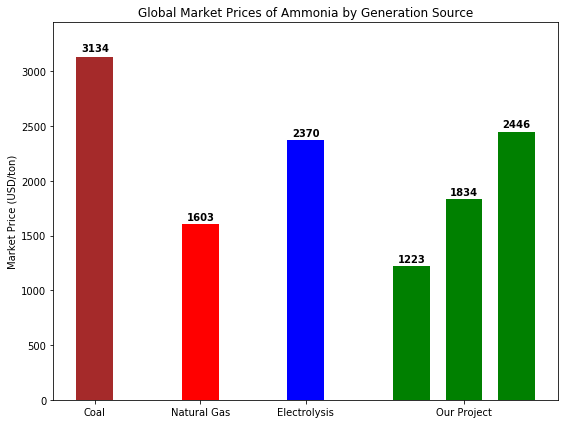

In [461]:
natural_gas = 1603
electrolysis = 2370
coal = 3134
wind_ammonia = production_ammonia_price(params_baseline)

data = [coal, natural_gas, electrolysis, wind_ammonia, wind_ammonia*1.5, wind_ammonia*2]
labels = ["Coal", "Natural Gas", "Electrolysis", "Our Project"]
colors = ['brown', 'red', 'blue', 'green']

fig, ax = plt.subplots(figsize=(8,6))
width = 0.35

for i in range(len(data[:-2])):
    ax.bar(i+1, data[i], width=width, color=colors[i])
ax.bar(len(data[:-2])+0.5, data[3]*1.5, width=width, color=colors[i])
ax.bar(len(data[:-2])+1, data[3]*2, width=width, color=colors[i])
for rect, label in zip(ax.patches, data):
    height = rect.get_height()
    width = rect.get_x()+rect.get_width()/2
    ax.text(width, height*1.01, str(int(label)), ha='center', va='bottom', fontweight='bold')
plt.xticks([1, 2, 3, 4.5], labels)
ax.set_ylim(0, np.max(data)*1.1)
ax.set_ylabel("Market Price (USD/ton)")
ax.set_title("Global Market Prices of Ammonia by Generation Source")

fig.tight_layout()
plt.show()

#### Cost Multipliers

In [462]:
def apply_multipliers_single_param(params, param_name, multipliers):
    params_multiplied = []
    for m in multipliers:
        params_m = params.copy()
        params_m[param_name] *= m
        params_multiplied.append(params_m)
    return params_multiplied

def calculate_with_multipliers(params, param_name, multipliers, func_name):
    params_multiplied = apply_multipliers_single_param(params, param_name, multipliers)
    calculations = np.asarray([func_name(pm) for pm in params_multiplied])
    return calculations

def sensitivity_to_multipliers(params, param_names, multipliers, value_func):
    param_name_to_prices = dict()
    for p in param_names:
        calculations = calculate_with_multipliers(params, p, multipliers, value_func)
        param_name_to_prices[p] = calculations
    return param_name_to_prices

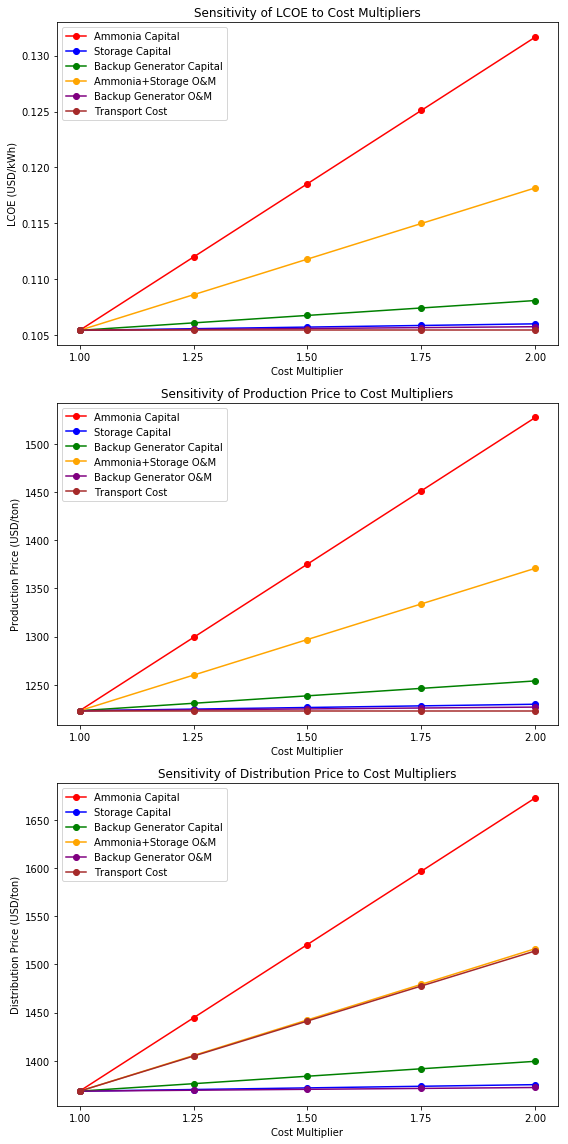

In [463]:
param_names = ['cc_ammonia', 'cc_storage', 'cc_backup', 'om_ammonia', 'om_backup', 'tr_cost']
multipliers = np.arange(1, 2.25, 0.25)

lcoe_multiplied = sensitivity_to_multipliers(params_baseline, param_names, multipliers, lcoe_wind_ammonia)
production_price_multiplied = sensitivity_to_multipliers(params_baseline, param_names, multipliers, production_ammonia_price)
distribution_price_multiplied = sensitivity_to_multipliers(params_baseline, param_names, multipliers, distribution_ammonia_price)

titles = ["LCOE", "Production Price", "Distribution Price"]
labels = ["Ammonia Capital", "Storage Capital", "Backup Generator Capital", "Ammonia+Storage O&M", "Backup Generator O&M", "Transport Cost"]
colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown']
ylabels = ["LCOE (USD/kWh)", "Production Price (USD/ton)", "Distribution Price (USD/ton)"]
data_to_plot = [lcoe_multiplied, production_price_multiplied, distribution_price_multiplied]

fig, axs = plt.subplots(len(data_to_plot), figsize=(8, 16))

for i in range(len(data_to_plot)):
    ax = axs[i]
    x = multipliers
    dp = data_to_plot[i]
    for j in range(len(param_names)):
        p = param_names[j]
        ax.plot(x, dp[p], marker='o', label=labels[j], color=colors[j])
    ax.set_ylabel(ylabels[i])
    ax.set_xlabel("Cost Multiplier")
    ax.set_xticks(x)
    ax.set_title("Sensitivity of {} to Cost Multipliers".format(titles[i]))
    ax.legend()

fig.tight_layout()
plt.show()

#### Cost Breakdowns

In [464]:
def total_cost_breakdown(params):
    capital = np.zeros([6])
    om_ammonia = om_cost_ammonia(params)
    om_other = om_cost_wind_ammonia(params)-om_cost_ammonia(params)
    capital_ammonia = params['cc_ammonia']*annual_ammonia_output(params)/365

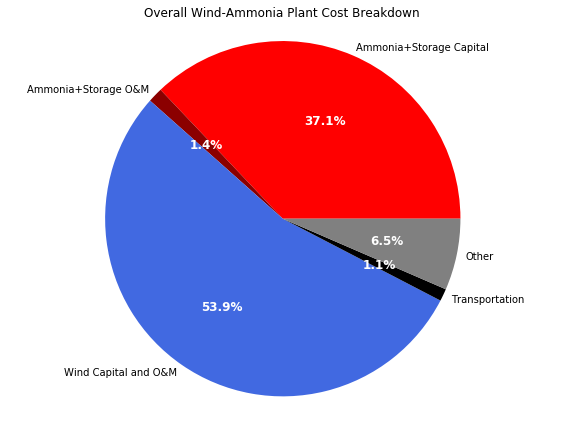

In [510]:
total = capital_cost_wind_ammonia(params_baseline)+om_cost_wind_ammonia(params_baseline)+transport_cost(params_baseline)
wind = capital_cost_wind_only(params_baseline)
ammonia_capital = capital_cost_ammonia(params_baseline)+capital_cost_storage(params_baseline)
ammonia_om = om_cost_ammonia(params_baseline)
transport = transport_cost(params_baseline)
other = total-wind-ammonia_capital-ammonia_om-transport

data = np.asarray([ammonia_capital, ammonia_om, wind, transport, other])
sizes = data/total

labels = ["Ammonia+Storage Capital", "Ammonia+Storage O&M", "Wind Capital and O&M", "Transportation", "Other"]
colors = ['red', 'darkred', 'royalblue', 'black', 'gray']

fig, ax = plt.subplots(figsize=(8,6))
_, _, texts = ax.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', labeldistance=1.05, startangle=0)
for text in texts:
    text.set_color('white')
    text.set_fontweight('bold')
    text.set_fontsize(12)
ax.axis('equal')
ax.set_title("Overall Wind-Ammonia Plant Cost Breakdown")

fig.tight_layout()
plt.show()

#### def capital_cost_breakdown(params, multipliers):
    capital = np.zeros([6])
    backup_factor = params['life_turbine']/params['life_backup']
    capital[0] = params['cc_land']*multipliers[0]
    capital[1] = params['cc_well']*multipliers[1]
    capital[2] = capital_cost_wind_only(params)*multipliers[2]
    capital[3] = params['cc_backup']*1e3*backup_generation_size(params)*backup_factor*multipliers[3]
    capital[4] = params['cc_ammonia']*annual_ammonia_output(params)/365*multipliers[4]
    capital[5] = params['cc_storage']*params['num_storage']*multipliers[5]
    return (capital, capital/np.sum(capital))

def om_cost_breakdown(params, multipliers):
    om = np.zeros([5])
    om[0] = om_cost_workers(params)*multipliers[0]
    om[1] = om_cost_turbine(params)*multipliers[1]
    om[2] = om_cost_backup(params)*multipliers[2]
    om[3] = om_cost_ammonia(params)*multipliers[3]
    om[4] = transport_cost(params)*multipliers[4]
    return (om, om/np.sum(om))

def format_percents(percents):
    return ["{:.2f}%".format(p*1e2) for p in percents]

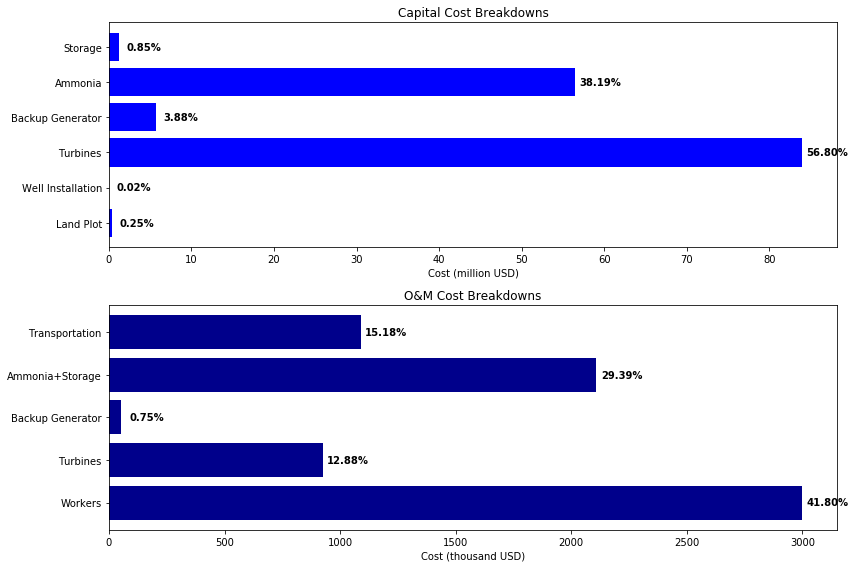

In [391]:
y_capital = np.arange(1, 7)
multipliers_capital = np.full(6, 1)
capital, capital_percents = capital_cost_breakdown(params_baseline, multipliers_capital)

y_om = np.arange(1, 6)
multipliers_om = np.full(5, 1)
om, om_percents = om_cost_breakdown(params_baseline, multipliers_om)

fig, (ax1, ax2) = plt.subplots(2, figsize=(12,8))

labels_capital = ["Land Plot", "Well Installation", "Turbines", "Backup Generator", "Ammonia", "Storage"]
rects = ax1.barh(y_capital, capital/1e6, color='blue', align='center')
for rect, label, w in zip(rects, format_percents(capital_percents), capital):
    height = rect.get_y()+rect.get_height()/2
    width = w/1e6+3 
    ax1.text(width, height, label, ha='center', va='center', color='black', weight='bold')
ax1.set_yticks(y_capital)
ax1.set_yticklabels(labels_capital)
ax1.set_xlabel('Cost (million USD)')

ax1.set_title("Capital Cost Breakdowns")
    
labels_om = ["Workers", "Turbines", "Backup Generator", "Ammonia+Storage", "Transportation"]
ax2.barh(y_om, om/1e3, color='darkblue', align='center')
for rect, label, w in zip(rects, format_percents(om_percents), om):
    height = rect.get_y()+rect.get_height()/2
    width = w/1e3+110
    ax2.text(width, height, label, ha='center', va='center', color='black', weight='bold')
ax2.set_yticks(y_om)
ax2.set_yticklabels(labels_om)
ax2.set_xlabel('Cost (thousand USD)')

ax2.set_title("O&M Cost Breakdowns")

fig.tight_layout()
plt.show()

#### Efficiency-Cost Tradeoffs

In [392]:
def linear_dec_one(frac, const):
    return (1+frac)*const

def linear_dec_twoX(frac, const):
    return (1+frac*2)*const

def linear_dec_halfX(frac, const):
    return (1+frac*0.5)*const

def apply_cost_energy_params(value_func, values_cost, values_energy, params):
    calculations = []
    for c, e in zip(values_cost, values_energy):
        params_altered = params.copy()
        params_altered['cc_ammonia'] = c
        params_altered['ammonia_energy_usage'] = e
        calculations.append([production_ammonia_price(params_altered)])
    return np.asarray(calculations)
    
def cost_efficiency_tradeoff(dec_func, value_func, params, reductions):
    values_cost = np.asarray([(1-r)*params['cc_ammonia'] for r in reductions])
    values_energy = np.asarray([dec_func(r, params['ammonia_energy_usage']) for r in reductions])
    calculations = apply_cost_energy_params(value_func, values_cost, values_energy, params)
    return values_cost, values_energy, calculations

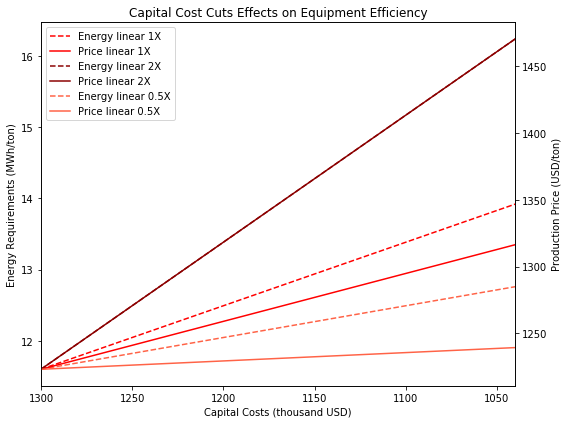

In [393]:
dec_funcs = [linear_dec_one, linear_dec_twoX, linear_dec_halfX]
reductions = np.arange(0.0, 0.25, 0.05)

data_to_plot = [cost_efficiency_tradeoff(d, lcoe_wind_ammonia, params_baseline, reductions) for d in dec_funcs]

labels = ["linear 1X", "linear 2X", "linear 0.5X"]
colors = ['red', 'darkred', 'tomato']

fig, ax = plt.subplots(figsize=(8,6))

lines = []
axT = ax.twinx()
for i in range(len(data_to_plot)):
    dp = data_to_plot[i]
    x = dp[0]/1e3
    l1 = ax.plot(x, dp[1], color=colors[i], linestyle='dashed', label="Energy {}".format(labels[i]))
    l2 = axT.plot(x, dp[2], color=colors[i], label="Price {}".format(labels[i]))
    lines += l1
    lines += l2
ax.set_xlim(np.max(x), np.min(x))
ax.set_xlabel("Capital Costs (thousand USD)")
ax.set_ylabel("Energy Requirements (MWh/ton)")
axT.set_ylabel("Production Price (USD/ton)")
ax.set_title("Capital Cost Cuts Effects on Equipment Efficiency")
line_labels = [l.get_label() for l in lines]
ax.legend(lines, line_labels, loc=0)

fig.tight_layout()
plt.show()

In [394]:
def exponential_dec_med(frac, const):
    return const*np.e**(-1*frac*10)

def exponential_dec_fast(frac, const):
    return const*np.e**(-1*frac*2*10)

def exponential_dec_slow(frac, const):
    return const*np.e**(-1*frac*0.5*10)

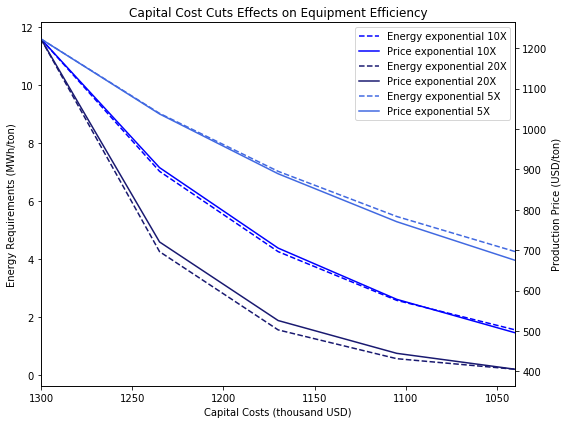

In [395]:
dec_funcs = [exponential_dec_med, exponential_dec_fast, exponential_dec_slow]
reductions = np.arange(0.0, 0.25, 0.05)

data_to_plot = [cost_efficiency_tradeoff(d, lcoe_wind_ammonia, params_baseline, reductions) for d in dec_funcs]

labels = ["exponential 10X", "exponential 20X", "exponential 5X"]
colors = ['blue', 'midnightblue', 'royalblue']

fig, ax = plt.subplots(figsize=(8,6))

lines = []
axT = ax.twinx()
for i in range(len(data_to_plot)):
    dp = data_to_plot[i]
    x = dp[0]/1e3
    l1 = ax.plot(x, dp[1], color=colors[i], linestyle='dashed', label="Energy {}".format(labels[i]))
    l2 = axT.plot(x, dp[2], color=colors[i], label="Price {}".format(labels[i]))
    lines += l1
    lines += l2
ax.set_xlim(np.max(x), np.min(x))
ax.set_xlabel("Capital Costs (thousand USD)")
ax.set_ylabel("Energy Requirements (MWh/ton)")
axT.set_ylabel("Production Price (USD/ton)")
ax.set_title("Capital Cost Cuts Effects on Equipment Efficiency")
line_labels = [l.get_label() for l in lines]
ax.legend(lines, line_labels, loc=0)

fig.tight_layout()
plt.show()